EC9580 - Computer Vision - Lab01

Sumanarathna E.G.T.M - 2020/E/152

In [74]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Question 01

task 01

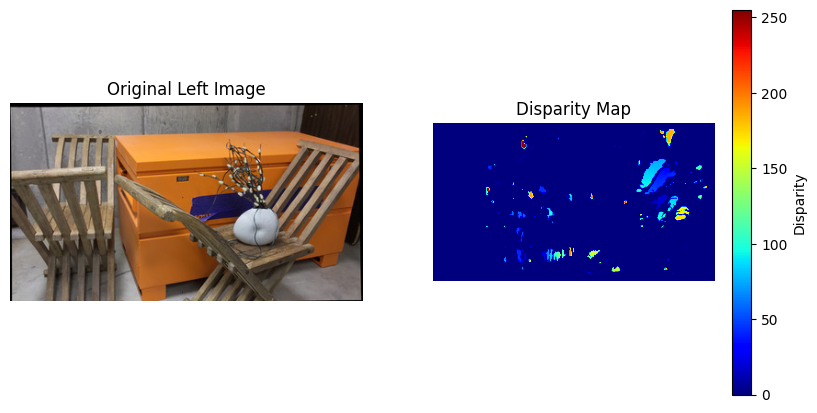

In [75]:
def compute_disparity_map(left_img, right_img):
    left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
    stereo = cv2.StereoBM_create(numDisparities=16*4, blockSize=21)
    disparity = stereo.compute(left_gray, right_gray)
    normalized_disparity = cv2.normalize(disparity, None, alpha=0, beta=255,
                                       norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Left Image')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(normalized_disparity, cmap='jet')
    plt.colorbar(label='Disparity')
    plt.title('Disparity Map')
    plt.axis('off')
    plt.show()
    return disparity, normalized_disparity

left_img = cv2.imread('/content/drive/MyDrive/EC9580_Lab01_Images/left_image.jpg')
right_img = cv2.imread('/content/drive/MyDrive/EC9580_Lab01_Images/right_image.jpg')
disparity, normalized_disparity = compute_disparity_map(left_img, right_img)

task 02

In [76]:
def calculate_depth_map(disparity, focal_length, baseline):
    disparity = disparity.astype(float)
    disparity[disparity == 0] = 0.1
    depth = (focal_length * baseline) / disparity
    depth[depth > 10] = 10
    depth[depth < 0] = 0
    return depth

FOCAL_LENGTH = 940
BASELINE = 0.1

depth_map = calculate_depth_map(disparity, FOCAL_LENGTH, BASELINE)
print(depth_map)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


task 03

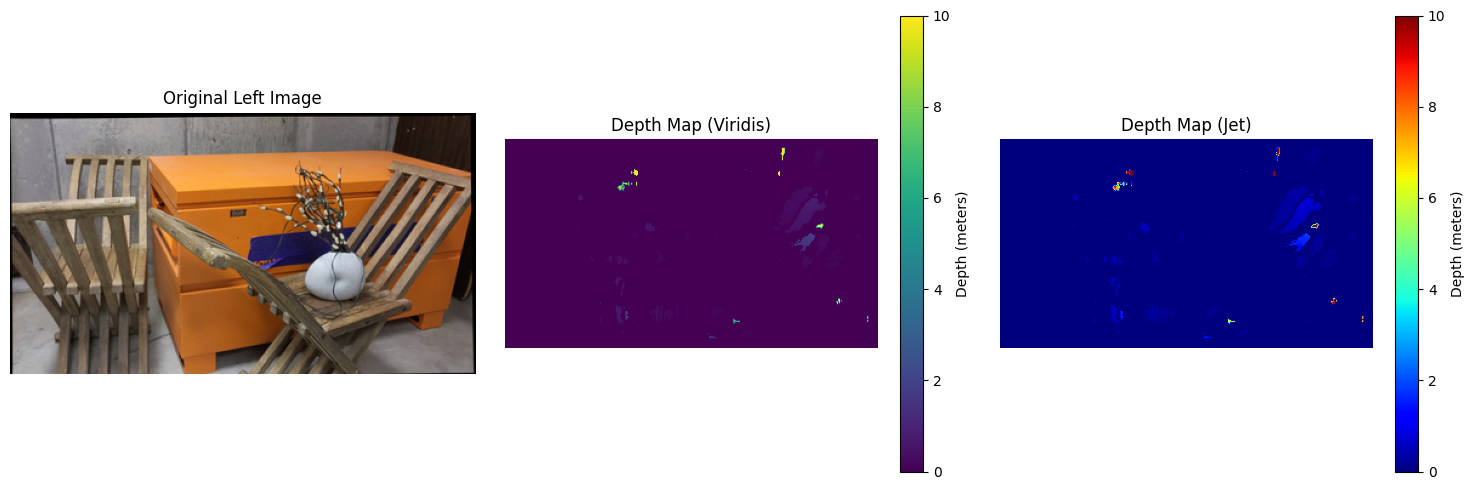

In [77]:
def visualize_depth_map(left_img, depth_map):
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Left Image')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(depth_map, cmap='viridis')
    plt.colorbar(label='Depth (meters)')
    plt.title('Depth Map (Viridis)')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(depth_map, cmap='jet')
    plt.colorbar(label='Depth (meters)')
    plt.title('Depth Map (Jet)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_depth_map(left_img, depth_map)

task 04

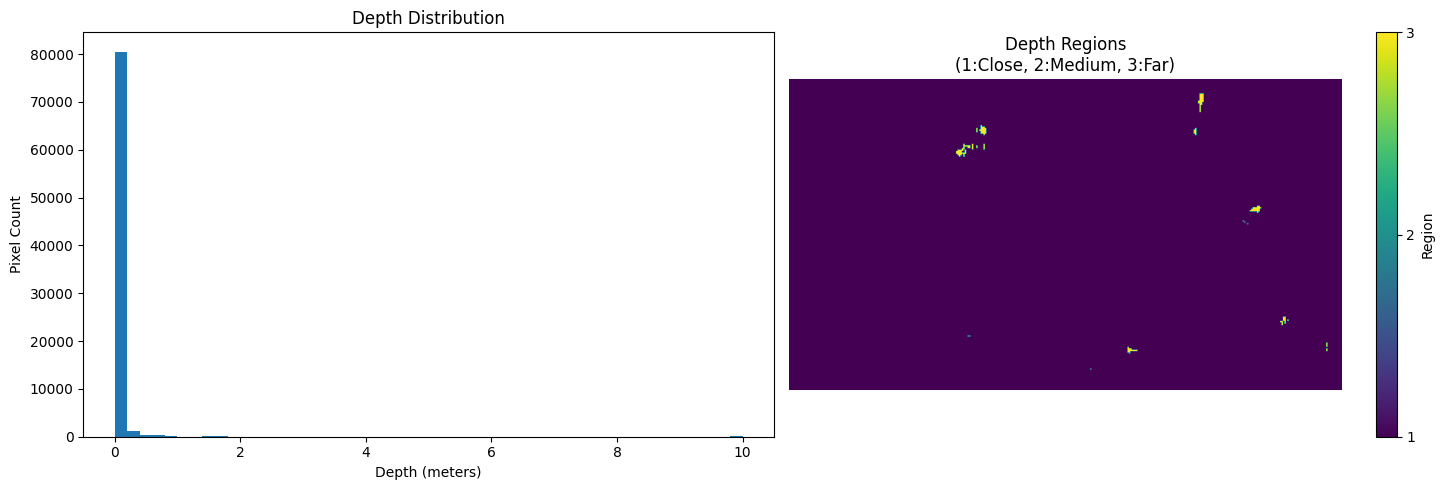


Depth Map Analysis:
Minimum depth: 0.00 meters
Maximum depth: 10.00 meters
Mean depth: 0.03 meters
Median depth: 0.00 meters
Depth standard deviation: 0.43 meters


In [78]:
def analyze_depth_map(depth_map):
    depth_stats = {
        'min_depth': np.min(depth_map),
        'max_depth': np.max(depth_map),
        'mean_depth': np.mean(depth_map),
        'median_depth': np.median(depth_map),
        'std_depth': np.std(depth_map)
    }
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.hist(depth_map.ravel(), bins=50)
    plt.title('Depth Distribution')
    plt.xlabel('Depth (meters)')
    plt.ylabel('Pixel Count')
    plt.subplot(122)
    depth_regions = np.copy(depth_map)
    depth_regions[depth_map < 2] = 1
    depth_regions[(depth_map >= 2) & (depth_map < 5)] = 2
    depth_regions[depth_map >= 5] = 3
    plt.imshow(depth_regions, cmap='viridis')
    plt.colorbar(ticks=[1, 2, 3], label='Region')
    plt.title('Depth Regions\n(1:Close, 2:Medium, 3:Far)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("\nDepth Map Analysis:")
    print(f"Minimum depth: {depth_stats['min_depth']:.2f} meters")
    print(f"Maximum depth: {depth_stats['max_depth']:.2f} meters")
    print(f"Mean depth: {depth_stats['mean_depth']:.2f} meters")
    print(f"Median depth: {depth_stats['median_depth']:.2f} meters")
    print(f"Depth standard deviation: {depth_stats['std_depth']:.2f} meters")
    return depth_stats

depth_stats = analyze_depth_map(depth_map)

### Question 02

task 01

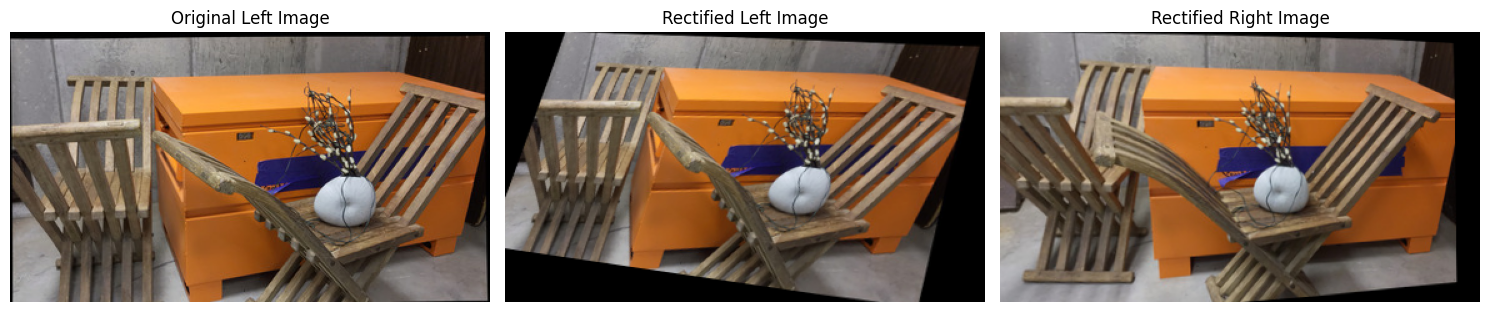

In [79]:
def rectify_stereo_images(left_img, right_img):
    left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(left_gray, None)
    kp2, des2 = sift.detectAndCompute(right_gray, None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
    h1, w1 = left_gray.shape
    h2, w2 = right_gray.shape
    _, H1, H2 = cv2.stereoRectifyUncalibrated(pts1, pts2, F, (w1, h1))
    left_rectified = cv2.warpPerspective(left_img, H1, (w1, h1))
    right_rectified = cv2.warpPerspective(right_img, H2, (w2, h2))
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Left Image')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(cv2.cvtColor(left_rectified, cv2.COLOR_BGR2RGB))
    plt.title('Rectified Left Image')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(cv2.cvtColor(right_rectified, cv2.COLOR_BGR2RGB))
    plt.title('Rectified Right Image')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return left_rectified, right_rectified

left_rectified, right_rectified = rectify_stereo_images(left_img, right_img)

task 02

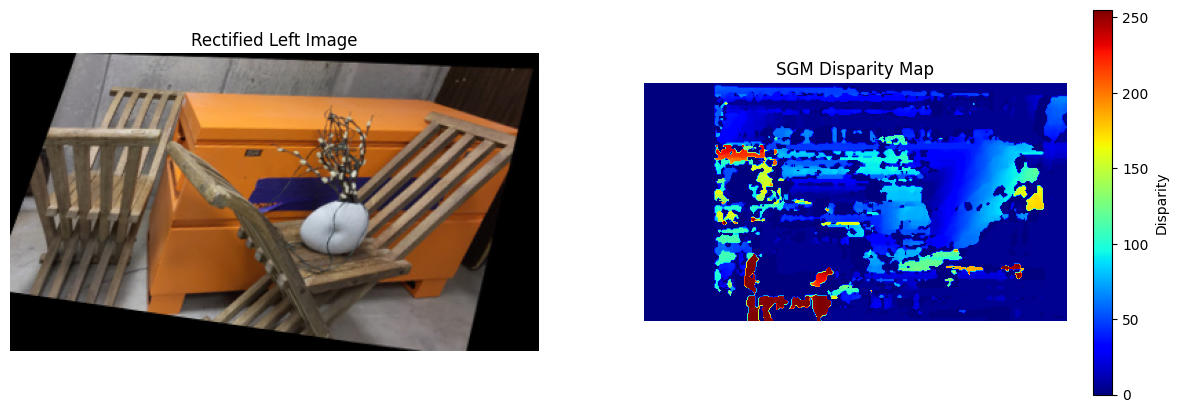

In [80]:
def compute_sgm_disparity(left_rectified, right_rectified):
    left_gray = cv2.cvtColor(left_rectified, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right_rectified, cv2.COLOR_BGR2GRAY)
    stereo_sgbm = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=16*4,
        blockSize=5,
        P1=8 * 3 * 5**2,
        P2=32 * 3 * 5**2,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    disparity_sgm = stereo_sgbm.compute(left_gray, right_gray)
    normalized_disparity = cv2.normalize(disparity_sgm, None, alpha=0, beta=255,
                                       norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(left_rectified, cv2.COLOR_BGR2RGB))
    plt.title('Rectified Left Image')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(normalized_disparity, cmap='jet')
    plt.colorbar(label='Disparity')
    plt.title('SGM Disparity Map')
    plt.axis('off')
    plt.show()
    return disparity_sgm, normalized_disparity

disparity_sgm, normalized_disparity_sgm = compute_sgm_disparity(left_rectified, right_rectified)

task 03

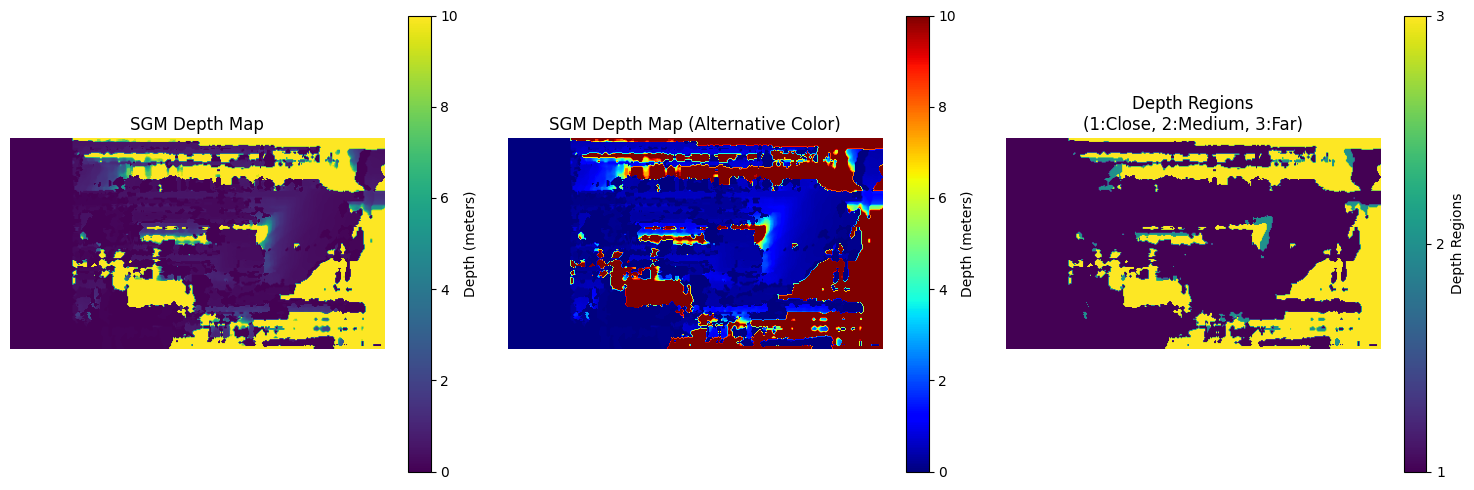

In [81]:
def calculate_sgm_depth_map(disparity_sgm, focal_length, baseline):
    disparity_sgm = disparity_sgm.astype(float)
    disparity_sgm[disparity_sgm == 0] = 0.1
    depth_sgm = (focal_length * baseline) / disparity_sgm
    depth_sgm[depth_sgm > 10] = 10
    depth_sgm[depth_sgm < 0] = 0
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(depth_sgm, cmap='viridis')
    plt.colorbar(label='Depth (meters)')
    plt.title('SGM Depth Map')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(depth_sgm, cmap='jet')
    plt.colorbar(label='Depth (meters)')
    plt.title('SGM Depth Map (Alternative Color)')
    plt.axis('off')
    plt.subplot(133)
    depth_regions = np.copy(depth_sgm)
    depth_regions[depth_sgm < 2] = 1
    depth_regions[(depth_sgm >= 2) & (depth_sgm < 5)] = 2
    depth_regions[depth_sgm >= 5] = 3
    plt.imshow(depth_regions, cmap='viridis')
    plt.colorbar(ticks=[1, 2, 3], label='Depth Regions')
    plt.title('Depth Regions\n(1:Close, 2:Medium, 3:Far)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return depth_sgm

depth_sgm = calculate_sgm_depth_map(disparity_sgm, FOCAL_LENGTH, BASELINE)

task 04

Mean Depth: 4.60 meters
Median Depth: 1.36 meters
Min Depth: 0.09 meters
Max Depth: 10.00 meters


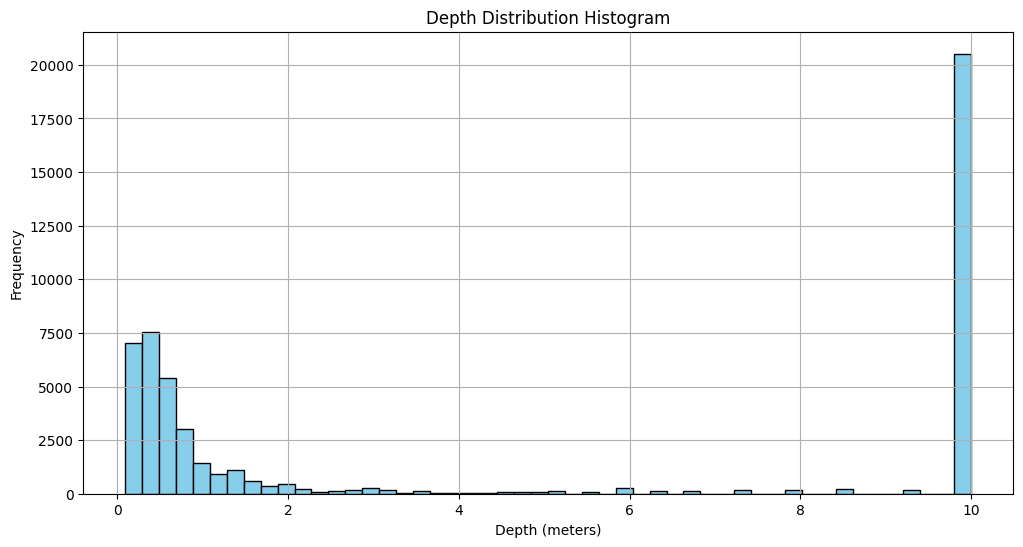

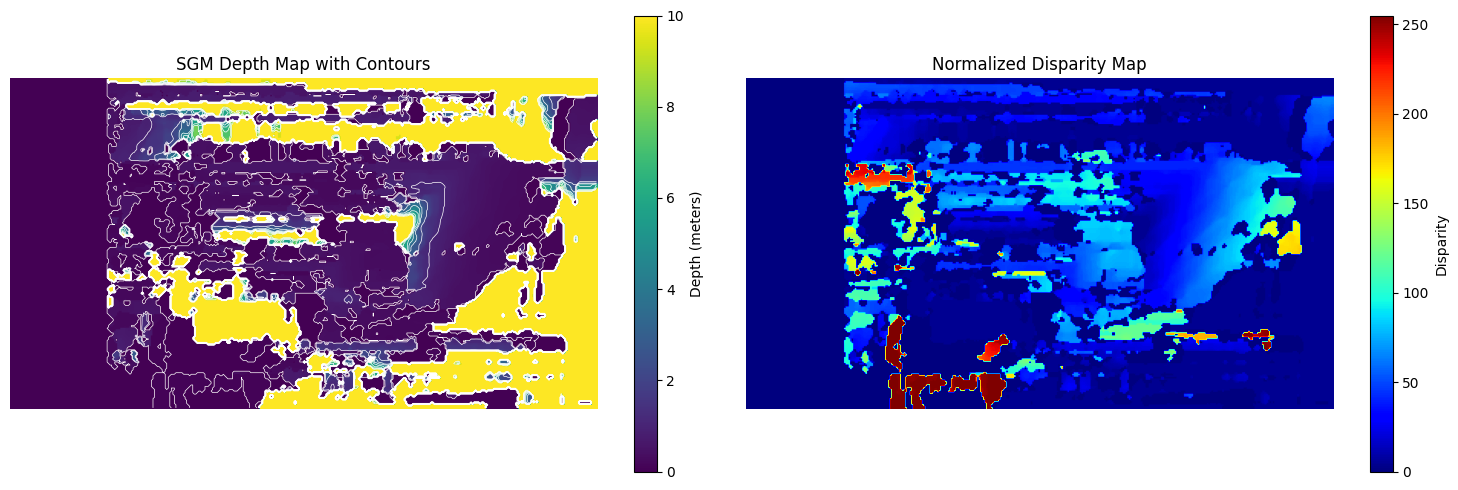

In [82]:
def analyze_and_visualize_depth(depth_sgm, normalized_disparity):
    valid_depths = depth_sgm[depth_sgm > 0]
    mean_depth = np.mean(valid_depths)
    median_depth = np.median(valid_depths)
    min_depth = np.min(valid_depths)
    max_depth = np.max(valid_depths)

    print(f"Mean Depth: {mean_depth:.2f} meters")
    print(f"Median Depth: {median_depth:.2f} meters")
    print(f"Min Depth: {min_depth:.2f} meters")
    print(f"Max Depth: {max_depth:.2f} meters")

    plt.figure(figsize=(12, 6))
    plt.hist(valid_depths.flatten(), bins=50, color='skyblue', edgecolor='black')
    plt.title('Depth Distribution Histogram')
    plt.xlabel('Depth (meters)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.imshow(depth_sgm, cmap='viridis')
    plt.colorbar(label='Depth (meters)')
    plt.contour(depth_sgm, levels=10, colors='white', linewidths=0.5)
    plt.title('SGM Depth Map with Contours')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(normalized_disparity, cmap='jet')
    plt.colorbar(label='Disparity')
    plt.title('Normalized Disparity Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    def generate_point_cloud(depth_map, focal_length):
        h, w = depth_map.shape
        Q = np.array([[1, 0, 0, -w//2],
                      [0, -1, 0, h//2],
                      [0, 0, 0, -focal_length],
                      [0, 0, 1, 0]])

        points_3D = cv2.reprojectImageTo3D(depth_map, Q)
        mask = (depth_map > 0) & (depth_map < 10)
        points_3D = points_3D[mask]

        return points_3D

analyze_and_visualize_depth(depth_sgm, normalized_disparity_sgm)